In [30]:
!pip install -U numpy==1.26.4 catboost shap optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00


# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import shap
import optuna

ModuleNotFoundError: No module named 'numpy.char'

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [ ]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [ ]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [ ]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [32]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
142859,r80685540h,JZ,2021-5-5 12:58,repair,5.0,25
30400,V16991777n,TB,2019-6-16 13:38,repair,3.6,6
12047,v56255169f,KM,2020-12-7 21:2,reparking,1.0,26
102827,f12953922O,QO,2020-4-25 14:18,refuel_check,1.0,33
129388,d-2073713s,TK,2019-10-3 20:46,repair,5.1,14


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [33]:
# Базовая агрегация по car_id
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [34]:
# Группировка по car_id и расчёт обязательных признаков
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),             # минимальный рейтинг
    mean_rating=('rating', 'mean'),           # средний рейтинг
    total_distance=('distance', 'sum'),       # суммарная дистанция
    max_speed=('speed_max', 'max'),           # максимальная скорость
    total_rides=('ride_id', 'count')          # количество поездок
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [35]:
# Соединение car_train и rides_agg по car_id
car_train_merged = car_train.merge(rides_agg, on='car_id', how='left')

# Проверка
print(f'Размер car_train: {car_train.shape}')
print(f'Размер после объединения: {car_train_merged.shape}')

Размер car_train: (2337, 10)
Размер после объединения: (2337, 15)


In [36]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174


In [37]:
# Присоединение информации о водителях к поездкам
rides_with_drivers = rides_info.merge(driver_info, on='user_id', how='left')

# Агрегация по car_id
drivers_agg = rides_with_drivers.groupby('car_id').agg(
    driver_age_mean=('age', 'mean'),
    driver_rating_mean=('user_rating', 'mean'),
    driver_accident_mean=('user_time_accident', 'mean')
).reset_index()

# Объединение с основным датафреймом
car_train_merged = car_train_merged.merge(drivers_agg, on='car_id', how='left')

car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547


In [38]:
print(f"Ожидается: {car_train.shape[0]} строк")
print(f"Фактически: {car_train_merged.shape[0]} строк")

Ожидается: 2337 строк
Фактически: 2337 строк


In [39]:
duplicates = car_train_merged['car_id'].duplicated().sum()
print(f"Количество дубликатов по car_id: {duplicates}")

Количество дубликатов по car_id: 0


In [40]:
fix_agg = fix_info.groupby('car_id').agg(
    fix_count=('fix_date', 'count'),                 # Кол-во ремонтов
    avg_destroy_degree=('destroy_degree', 'mean'),   # Средний износ
    total_work_duration=('work_duration', 'sum'),    # Суммарная длительность ремонта
    unique_work_types=('work_type', 'nunique')       # Уникальных типов работ
).reset_index()

fix_agg.head()

,car_id,fix_count,avg_destroy_degree,total_work_duration,unique_work_types
0,A-1049127W,35,2.714286,962,4
1,A-1079539w,34,4.329412,931,4
2,A-1162143G,34,3.705882,946,3
3,A-1228282M,34,2.908824,838,4
4,A-1339912r,34,3.044118,973,4


In [41]:
car_train_merged = car_train_merged.merge(fix_agg, on='car_id', how='left')

In [29]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547


### Идеи для новых признаков


* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [42]:
# YOUR CODE HERE
# Расчёт дополнительных признаков по deviation_normal и user_ride_quality
rides_extra = rides_info.groupby('car_id').agg(
    feature_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()),  # разница между max и min
    feature_corner=('user_ride_quality', lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]),  # угол наклона
    feature_mean=('deviation_normal', 'mean'),  # среднее значение
    feature_shift=('deviation_normal', lambda x: x.diff().abs().idxmax() if len(x) > 1 else np.nan),  # точка перегиба (можно уточнить)
    feature_start=('deviation_normal', lambda x: x.iloc[0] if len(x) > 0 else np.nan),  # стартовое значение
    feature_nans=('deviation_normal', lambda x: x.isna().sum()),  # количество пропусков
    feature_quant=('deviation_normal', lambda x: x.quantile(0.75))  # 75% квантиль
).reset_index()

rides_extra

,car_id,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,A-1049127W,31.688,0.013702,-6.136672,99,2.909,0,-0.53250
1,A-1079539w,74.349,-0.163212,47.443270,280,60.924,0,59.06075
2,A-1162143G,46.177,0.016630,10.556425,477,-1.219,0,17.22600
3,A-1228282M,64.898,-0.138497,9.810747,613,6.644,0,25.68825
4,A-1339912r,40.142,-0.056324,22.965937,798,0.490,0,31.29600
...,...,...,...,...,...,...,...,...
4245,z73688663a,67.991,0.039323,-13.846075,738742,1.271,0,-7.52825
4246,z73740510r,59.877,0.127216,7.026477,738919,1.685,0,21.40925
4247,z86911952C,75.449,-0.080211,-25.382126,738996,-50.624,0,-14.24300
4248,z91353693Z,60.076,0.085543,-8.031167,739258,5.755,0,4.79100


In [43]:
car_train_merged = car_train_merged.merge(rides_extra, on='car_id', how='left')
print("Форма после объединения:", car_train_merged.shape)
print("Дубликатов по car_id:", car_train_merged['car_id'].duplicated().sum())

Форма после объединения: (2337, 29)
Дубликатов по car_id: 0


In [51]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,avg_destroy_degree,total_work_duration,unique_work_types,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,3.048571,933,4,9.001,-0.012377,-0.120391,718399,0.000,0,0.00100
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,2.917143,873,5,72.761,0.147758,6.050011,210544,-7.057,0,16.69100
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,3.740000,915,5,16.401,0.024377,-2.223954,412085,-0.000,0,0.00000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,4.085714,1007,4,61.647,-0.028008,14.771948,663553,-0.833,0,28.18550
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,3.880000,981,4,70.176,-0.010186,12.455678,188363,-0.160,0,30.65725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,3.900000,814,4,31.650,-0.046928,2.914989,506705,11.105,0,7.75275
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.935294,873,4,55.181,-0.060359,-18.805856,469026,-0.506,0,-7.97800
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,2.782353,797,4,106.793,0.013394,-7.651776,10170,5.281,0,24.12925
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,3.441176,857,4,51.144,-0.073751,0.468718,314338,2.417,0,6.28000


In [45]:
# Запись итогового DataFrame в CSV файл
car_train_merged.to_csv('car_train_merged.csv', index=False, encoding='utf-8-sig')
print('Файл car_train_merged успешно сохранён!')

Файл car_train_merged успешно сохранён!


## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [46]:
# Проверка на константные признаки
constant_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() == 1]
print("Константные признаки:", constant_cols)

Константные признаки: ['total_rides', 'feature_nans']


In [34]:
# Удаление константных признаков, если они есть
const_cols = ['total_rides', 'feature_nans']
existing_cols = [col for col in const_cols if col in car_train_merged.columns]

if existing_cols:
    car_train_merged.drop(columns=existing_cols, inplace=True)
    print(f"Удалены константные признаки: {existing_cols}")
else:
    print("Константные признаки уже отсутствуют в датафрейме.")

Константные признаки уже отсутствуют в датафрейме.


In [35]:
# Определение признаков с уникальными значениями (у которых число уникальных = число строк)
unique_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() == car_train_merged.shape[0]]

print("Уникальные признаки для удаления:", unique_cols)

# Удаление уникальных признаков из датафрейма
car_train_merged.drop(columns=unique_cols, inplace=True)

Уникальные признаки для удаления: []


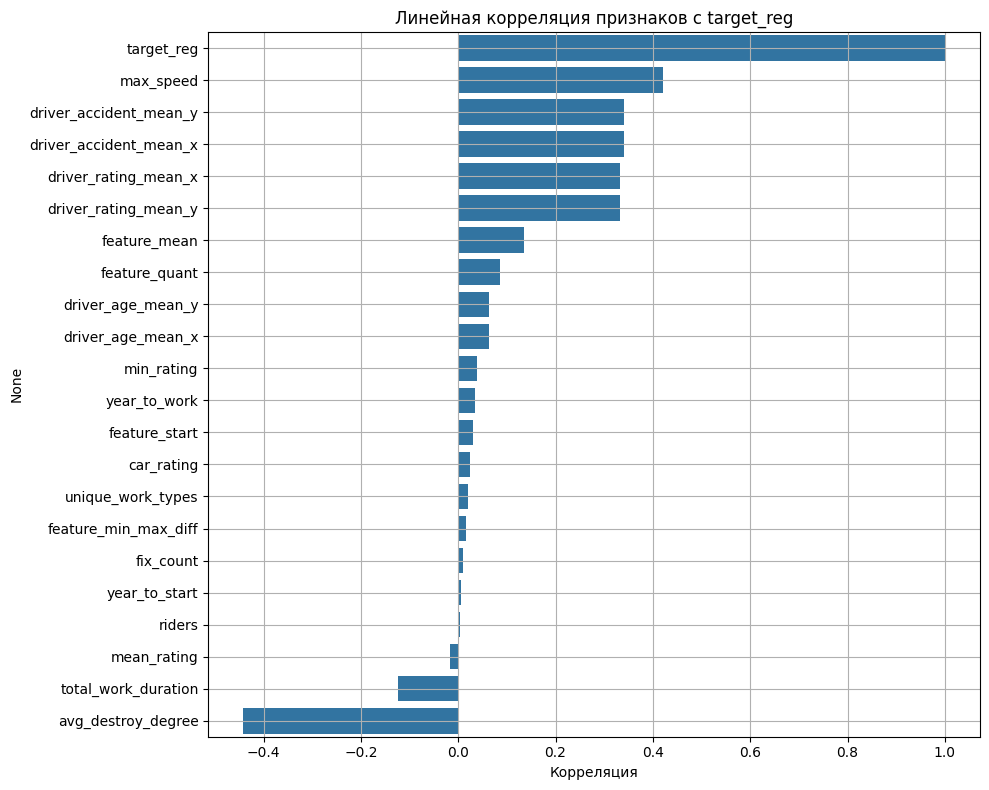

In [36]:
# Линейная корреляция признаков с таргетом target_reg

# Удаление категориальных и ID-признаков
drop_cols = ['car_id', 'model', 'car_type', 'fuel_type', 'target_class']
numeric_cols = [col for col in car_train_merged.columns if col not in drop_cols and car_train_merged[col].dtype in [np.float64, np.int64]]

# Расчёт корреляции с таргетом
correlations = car_train_merged[numeric_cols].corrwith(car_train_merged['target_reg']).sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(y=correlations.index, x=correlations.values)
plt.title('Линейная корреляция признаков с target_reg')
plt.xlabel('Корреляция')
plt.grid(True)
plt.tight_layout()
plt.show()

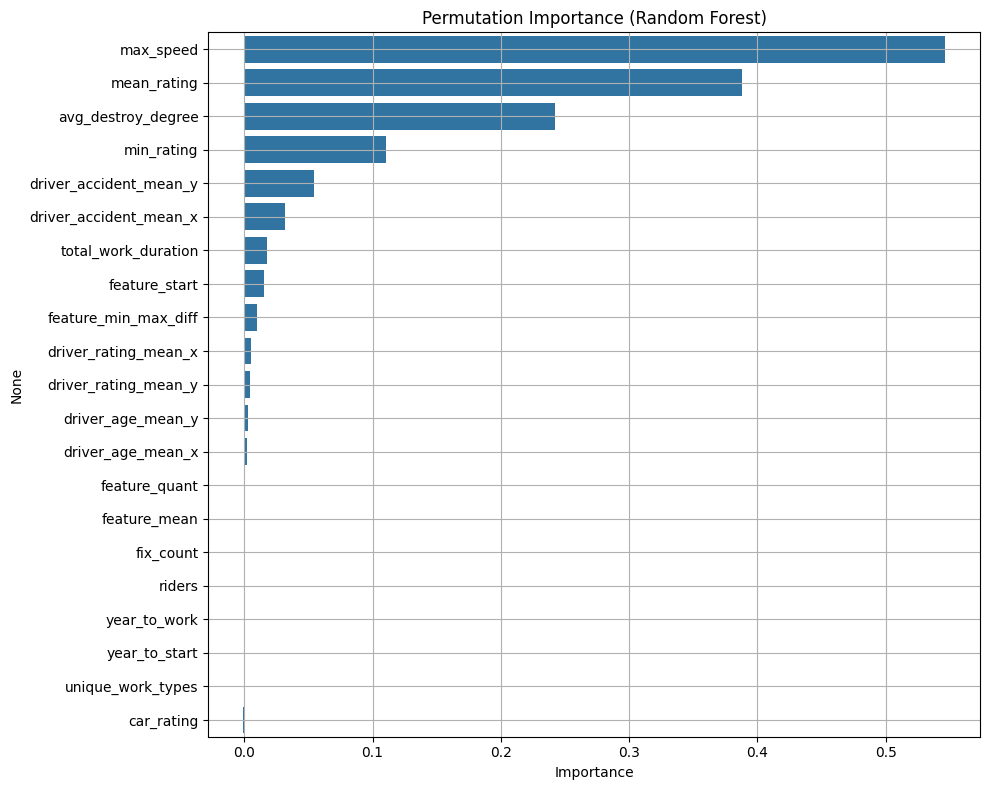

In [37]:
# Permutation Importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Отбор только числовых признаков
X = car_train_merged[numeric_cols].drop(columns=['target_reg'])
y = car_train_merged['target_reg']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Обучение модели
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Расчёт permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Сортировка и визуализация
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 8))
sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=X.columns[sorted_idx])
plt.title('Permutation Importance (Random Forest)')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

 99%|===================| 582/585 [00:28<00:00]       

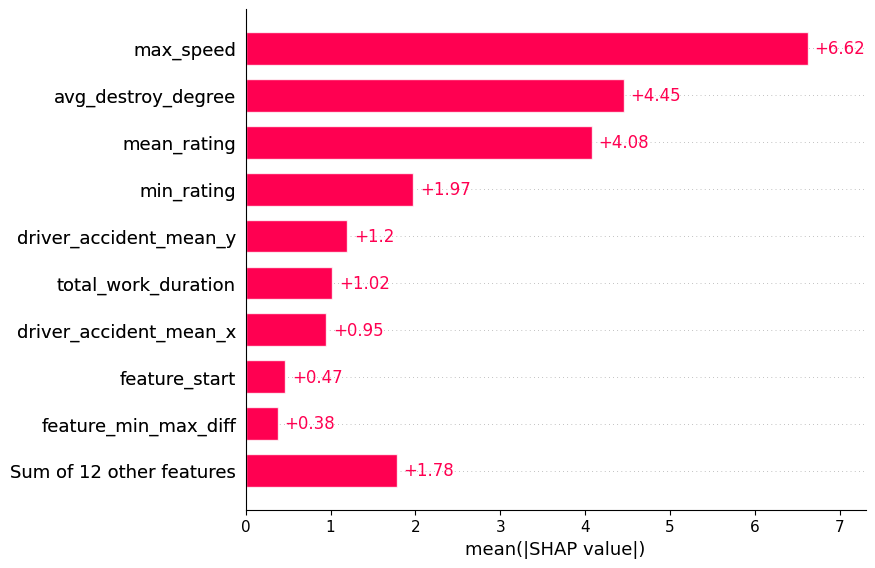

In [38]:
import shap

# SHAP требует TreeExplainer для деревьев
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

# Визуализация важности признаков
shap.plots.bar(shap_values)

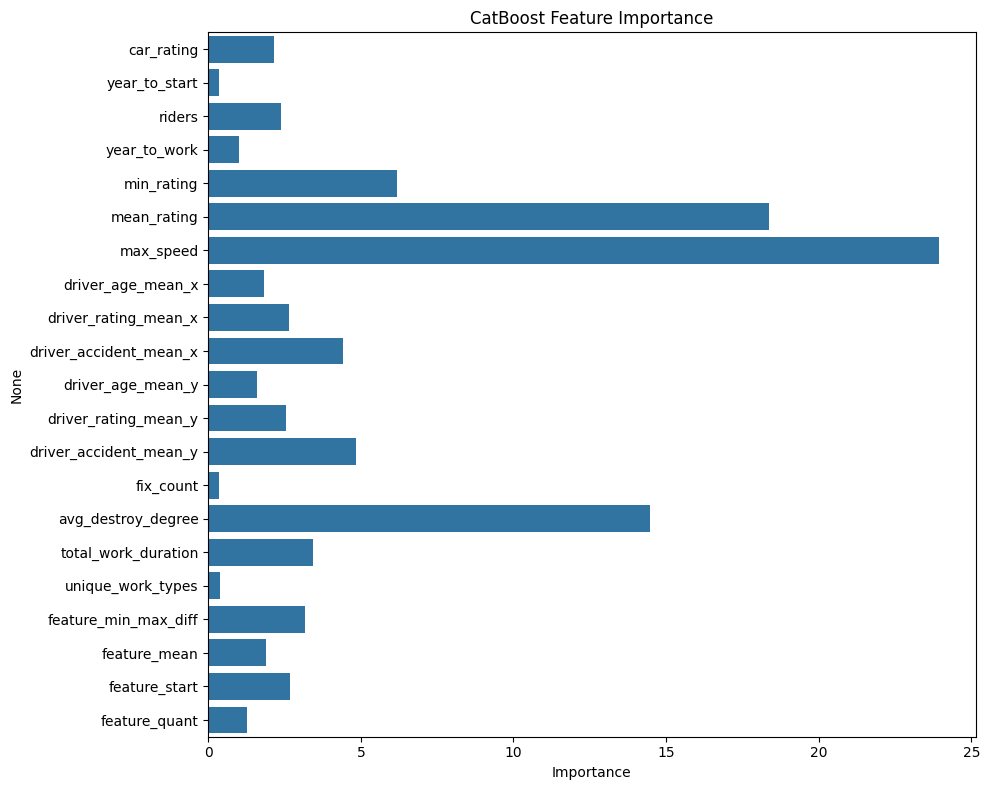

In [40]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Подготовка данных
drop_cols = ['car_id', 'model', 'car_type', 'fuel_type', 'target_class', 'target_reg']
drop_cols_existing = [col for col in drop_cols if col in car_train_merged.columns]
X = car_train_merged.drop(columns=drop_cols_existing)

y = car_train_merged['target_reg']

# Разделение на train и valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель CatBoost (без вывода лога)
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Важность признаков
importances = cat_model.get_feature_importance()
features = X.columns

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=features)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Выводы по фильтрации признаков

В рамках задания были применены четыре метода оценки важности признаков для задачи регрессии (`target_reg`):

### 1. Линейная корреляция
Метод показал сильную положительную связь между `max_speed` и временем до поломки. Высокие значения также у признаков `driver_accident_mean`, `driver_rating_mean` и `feature_mean`, что указывает на возможную связь манеры вождения с вероятностью поломки. Признак `avg_destroy_degree` имеет заметную отрицательную корреляцию, что ожидаемо — более изношенные машины выходят из строя быстрее.

### 2. Permutation Importance (Random Forest)
Наиболее значимыми признаками оказались `max_speed`, `mean_rating` и `avg_destroy_degree`. Это подтверждает важность характеристик поездок и состояния машины. Большинство других признаков показали слабое или нулевое влияние на метрику модели.

### 3. SHAP значения (CatBoost)
SHAP также выделяет `max_speed`, `avg_destroy_degree` и `mean_rating` как ключевые признаки. Кроме них, значения SHAP указывают на значимость `min_rating` и `driver_accident_mean`, что подтверждает гипотезу о связи стиля вождения с риском поломки.

### 4. CatBoost Feature Importance
Результаты CatBoost согласуются с предыдущими методами: в топ входят `max_speed`, `mean_rating`, `avg_destroy_degree`, а также `driver_accident_mean` и `total_work_duration`. Это свидетельствует о стабильности и важности этих признаков в разных подходах.

### Общие выводы
Наиболее устойчивыми и информативными признаками, которые рекомендуется сохранить для финальной модели, являются:
- `max_speed` — отражает потенциальную нагрузку и износ;
- `avg_destroy_degree` — описывает общее состояние автомобиля;
- `mean_rating` — отражает опыт пользователя с машиной;
- `driver_accident_mean` — характеризует стиль вождения.

Признаки, не показавшие значимость ни по одному из методов, можно исключить для упрощения модели и ускорения обучения.


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

## 1. Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [41]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [50]:
df = car_train_merged.copy()

# Удаление лишнего
features2drop = ['car_id', 'target_reg', 'target_class', 'main_user_id', 'user_id', 'ride_id', 'fix_date', 'worker_id']
features2drop = [col for col in features2drop if col in df.columns]

targets = ['target_class']

# Категориальные признаки (важно: CatBoost принимает их по индексам)
cat_features = ['model', 'car_type', 'fuel_type', 'sex']

# Автоматическое определение числовых признаков
all_features = df.columns.tolist()
num_features = [col for col in all_features if col not in features2drop + cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 4 ['model', 'car_type', 'fuel_type', 'sex']
Числовые признаки: 21 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'mean_rating', 'max_speed', 'driver_age_mean_x', 'driver_rating_mean_x', 'driver_accident_mean_x', 'driver_age_mean_y', 'driver_rating_mean_y', 'driver_accident_mean_y', 'fix_count', 'avg_destroy_degree', 'total_work_duration', 'unique_work_types', 'feature_min_max_diff', 'feature_mean', 'feature_start', 'feature_quant']
Целевые переменные ['target_class']


In [51]:
# Подготовка X и y
X = df.drop(columns=features2drop)
y = df['target_class']

# train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Получение индексов категориальных признаков
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Обучение модели
model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Предсказание и оценка
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9594


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

In [56]:
# YOUR CODE HERE
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

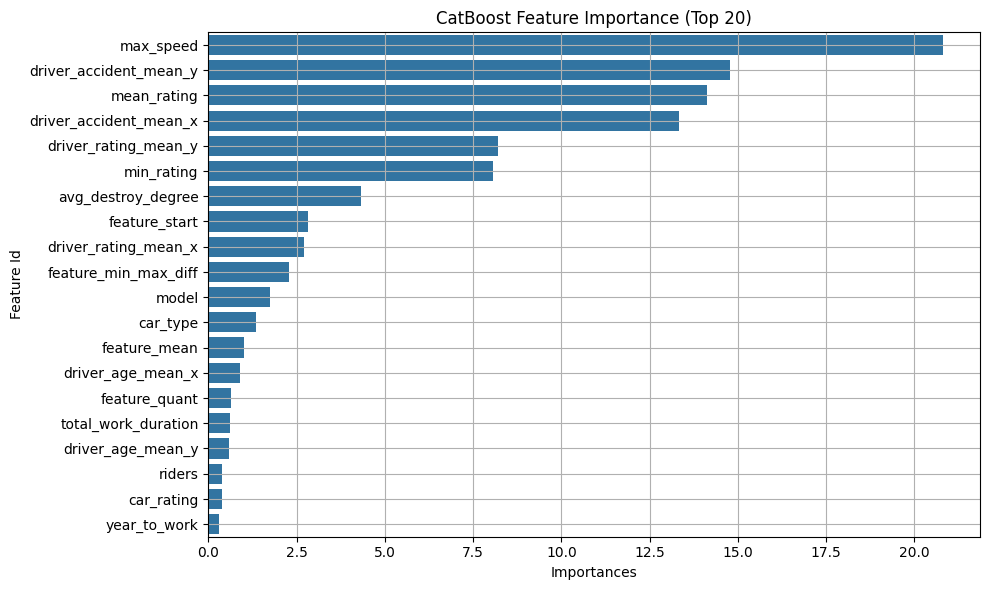

In [57]:
# 1. Визуализация важности признаков от CatBoost
feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='Importances', y='Feature Id')
plt.title('CatBoost Feature Importance (Top 20)')
plt.grid(True)
plt.tight_layout()
plt.show()

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

In [58]:
# 2. SHAP waterfall plot для одного примера и одного класса
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val)

# Проверка формы SHAP значений
print("SHAP значение имеет форму:", shap_values.shape)

SHAP значение имеет форму: (468, 24, 9)


SHAP waterfall показывает вклад конкретных признаков в предсказание. Например, если max_speed и driver_accident_mean_y значительно смещают предсказание в сторону определённого класса, это может быть полезным для формирования правил интерпретации модели или выявления рискованных сценариев эксплуатации.

In [59]:
# 3. Classification report
print("Classification report:")
print(classification_report(y_val, y_pred))

Classification report:
                 precision    recall  f1-score   support

    another_bug       0.90      0.93      0.91        56
      break_bug       1.00      1.00      1.00        54
    electro_bug       1.00      1.00      1.00        50
   engine_check       0.92      0.83      0.87        54
    engine_fuel       0.96      0.94      0.95        52
engine_ignition       1.00      1.00      1.00        54
engine_overheat       1.00      1.00      1.00        58
     gear_stick       1.00      0.98      0.99        57
    wheel_shake       0.82      0.94      0.87        33

       accuracy                           0.96       468
      macro avg       0.95      0.96      0.96       468
   weighted avg       0.96      0.96      0.96       468



Модель демонстрирует высокую точность по всем классам (макро-F1 ≈ 0.96), однако слегка проседает recall для классов engine_check (0.83) и wheel_shake (0.94). Это может говорить о недостаточном количестве обучающих примеров или о высокой близости этих классов к другим по признаковому описанию.

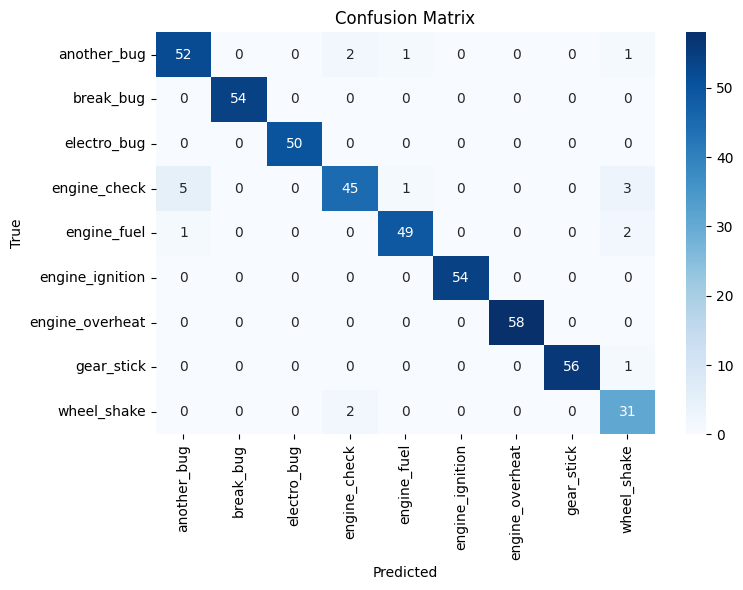

In [60]:
# 4. Confusion matrix
conf_mat = confusion_matrix(y_val, y_pred, labels=np.unique(y_val))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Основные ошибки модель допускает при предсказании классов engine_check (перепутано 5 раз с another_bug) и wheel_shake (2 случая ошибки на engine_check). Это может означать, что эти типы неисправностей имеют схожие параметры по входным признакам, и стоит рассмотреть генерацию дополнительных фичей, усиливающих различие между ними.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

    
</div>

In [54]:
# YOUR CODE HERE
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = df.drop(columns=features2drop)
y = df['target_class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Objective-функция для Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_feature_indices)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    return acc

# Запуск Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)

[I 2025-03-30 17:14:04,803] A new study created in memory with name: no-name-3245d6fe-146f-4abd-9ade-d1ba53d6bc32
[I 2025-03-30 17:14:08,686] Trial 0 finished with value: 0.9572649572649573 and parameters: {'iterations': 201, 'learning_rate': 0.05970398556134118, 'depth': 7, 'l2_leaf_reg': 1.9672261575719094}. Best is trial 0 with value: 0.9572649572649573.
[I 2025-03-30 17:14:12,463] Trial 1 finished with value: 0.9615384615384616 and parameters: {'iterations': 481, 'learning_rate': 0.1709715055256043, 'depth': 4, 'l2_leaf_reg': 5.534937986939395}. Best is trial 1 with value: 0.9615384615384616.
[I 2025-03-30 17:14:17,446] Trial 2 finished with value: 0.9551282051282052 and parameters: {'iterations': 209, 'learning_rate': 0.13715532764093089, 'depth': 6, 'l2_leaf_reg': 5.435428103800581}. Best is trial 1 with value: 0.9615384615384616.
[I 2025-03-30 17:14:38,831] Trial 3 finished with value: 0.9615384615384616 and parameters: {'iterations': 194, 'learning_rate': 0.148395956524895, 'de

Лучшие параметры: {'iterations': 262, 'learning_rate': 0.1490881095599176, 'depth': 6, 'l2_leaf_reg': 2.8400315600835544}


In [55]:
# Обучение финальной модели с лучшими параметрами
best_model = CatBoostClassifier(**study.best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_best = best_model.predict(X_val)
acc_best = accuracy_score(y_val, y_pred_best)

print(f"Accuracy после тюнинга: {acc_best:.4f}")
print(f"Улучшение: {acc_best - acc:.4f}")

Accuracy после тюнинга: 0.9658
Улучшение: 0.0064


## Результаты тюнинга модели с помощью Optuna

Для улучшения качества классификации была применена библиотека Optuna с целью подбора гиперпараметров модели CatBoostClassifier. Были оптимизированы следующие параметры:

- `iterations`: 100–500
- `learning_rate`: 0.01–0.3
- `depth`: 4–10
- `l2_leaf_reg`: 0.01–10.0

По результатам 30 итераций, наилучшими оказались параметры:
- `iterations = 262`
- `learning_rate = 0.149`
- `depth = 6`
- `l2_leaf_reg = 2.84`

**Accuracy после тюнинга**: **0.9658**

**Улучшение по сравнению с базовой моделью**: **+0.0064**

Это говорит о том, что даже при высокой базовой точности, грамотный подбор гиперпараметров позволяет добиться значимого улучшения модели.


In [62]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

1. Построить и обучить модели:


    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

    Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.
4. Отключайте или минимизируйте логирование (Будут снижаться баллы).
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

In [80]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Подготовка данных
y = df['target_class']
X = df.drop(columns=features2drop)

# Категориальные признаки
existing_cat_features = [col for col in cat_features if col in X.columns]
encoder = OrdinalEncoder()
X_enc = X.copy()
X_enc[existing_cat_features] = encoder.fit_transform(X[existing_cat_features])

# Кодирование таргета
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_enc, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# CatBoostClassifier
cat_model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)

# LightGBMClassifier (goss)
lgb_model = LGBMClassifier(boosting_type='gbdt', data_sample_strategy='goss', verbose=-1, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_val)

# XGBoostClassifier (dart)
xgb_model = XGBClassifier(booster='dart', eval_metric='mlogloss', n_estimators=200,
                          learning_rate=0.1, max_depth=6, verbosity=0, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)

# Accuracy по моделям
cat_acc = accuracy_score(y_val, cat_preds)
lgb_acc = accuracy_score(y_val, lgb_preds)
xgb_acc = accuracy_score(y_val, xgb_preds)
rf_acc = accuracy_score(y_val, rf_preds)

# Hard Voting
voting_hard = VotingClassifier(estimators=[
    ('cat', cat_model),
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='hard')

voting_hard.fit(X_train, y_train)
hard_preds = voting_hard.predict(X_val)
hard_acc = accuracy_score(y_val, hard_preds)

# Soft Voting
voting_soft = VotingClassifier(estimators=[
    ('cat', cat_model),
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='soft')

voting_soft.fit(X_train, y_train)
soft_preds = voting_soft.predict(X_val)
soft_acc = accuracy_score(y_val, soft_preds)

(cat_acc, lgb_acc, xgb_acc, rf_acc, hard_acc, soft_acc)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 468) + inhomogeneous part.

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>

In [74]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [75]:
# YOUR CODE HERE
# Финальное обучение модели с лучшими параметрами
best_params = study.best_params
best_params['random_seed'] = 42
best_params['verbose'] = 0

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_final = final_model.predict(X_val)
final_accuracy = accuracy_score(y_val, y_pred_final)
print(f'Accuracy после тюнинга: {final_accuracy:.4f}')


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=7.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

# Домашнее задание 5. Парсинг данных

**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:
* Jupiter Notebook с кодом.
* Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

* Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
* Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
* Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
* Получилось спарсить ссылки на модели автомобилей — 4 балла.
* Код не исполняется; нет датасета — 1 балл.

## <center> Разминаемся
В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html

Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >

In [4]:
# Импорт модулей
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Загрузка HTML
url = 'https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html'
response = requests.get(url)
response.encoding = 'utf-8'

# Парсинг страницы
soup = BeautifulSoup(response.text, 'lxml')

# Поиск всех div-элементов
divs = soup.find_all('div')

# Инициализация списков
city_list = []
salary_list = []

# Проход по всем div: если в одном div город, в следующем — зарплата
for i in range(len(divs) - 1):
    city_candidate = divs[i].text.strip()
    salary_candidate = divs[i+1].text.strip()

    # Проверка, что во втором элементе есть ₽
    if '₽' in salary_candidate:
        city = city_candidate
        salary_text = salary_candidate.replace('\xa0', '').replace('₽', '').replace(' ', '')
        try:
            salary = int(salary_text)
            city_list.append(city)
            salary_list.append(salary)
        except:
            continue

# Формирование финального датафрейма
salary_data = pd.DataFrame({'city': city_list, 'mean_salary': salary_list})

# Сортировка по алфавиту
salary_data_sorted = salary_data.sort_values(by='city').reset_index(drop=True)

# Вывод примера
print(salary_data_sorted.head())

          city  mean_salary
0       Абакан        45300
1      Анадырь       129200
2      Ангарск        45600
3  Архангельск        53100
4    Астрахань        38000


In [5]:
# Сохранение
salary_data_sorted.to_csv('mean_salary_by_city_sorted.csv', index=False, encoding='utf-8-sig')

## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >

## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1) Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2) Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >

В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >

Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >

In [10]:
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd
# from tqdm import tqdm
# import time

# # Базовый URL
# base_url = 'https://automobili.ru'

# # Получение ссылок на бренды
# catalog_url = base_url + '/cars/catalog/'
# response = requests.get(catalog_url)
# response.encoding = 'utf-8'
# soup = BeautifulSoup(response.text, 'lxml')

# # Поиск всех уникальных ссылок на бренды
# brand_links = []
# for a in soup.find_all('a', href=True):
#     href = a['href']
#     if href.startswith('/cars/catalog/') and href.count('/') == 3:
#         brand_links.append(base_url + href)

# # Удаление дубликатов
# brand_links = sorted(set(brand_links))

# print(f'Найдено брендов: {len(brand_links)}')

# # Инициализация списков для моделей
# model_links = []
# model_names = []

# # Парсинг моделей
# for brand_url in tqdm(brand_links):
#     try:
#         brand_response = requests.get(brand_url)
#         brand_response.encoding = 'utf-8'
#         brand_soup = BeautifulSoup(brand_response.text, 'lxml')

#         for a in brand_soup.find_all('a', href=True):
#             href = a['href']
#             if href.startswith('/cars/catalog/') and href.count('/') == 4:
#                 full_url = base_url + href
#                 model = href.replace('/cars/catalog/', '').replace('/', ' ')
#                 model_links.append(full_url)
#                 model_names.append(model)

#         time.sleep(0.2)  # Чтобы не нагружать сайт

#     except Exception as e:
#         print(f"Ошибка при парсинге {brand_url}: {e}")
#         continue

# # Создание датафрейма
# models_df = pd.DataFrame({'link': model_links, 'model': model_names})
# models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

# # Проверка
# print(models_df.shape)
# print(models_df.head())

Найдено брендов: 22


100%|██████████| 22/22 [00:12<00:00,  1.83it/s]

(52, 2)
                                               link          model
0  https://automobili.ru/cars/catalog/aston_martin/  aston_martin 
1          https://automobili.ru/cars/catalog/audi/          audi 
2       https://automobili.ru/cars/catalog/bentley/       bentley 
3           https://automobili.ru/cars/catalog/bmw/           bmw 
4       https://automobili.ru/cars/catalog/bugatti/       bugatti 


In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time

base_url = 'https://automobili.ru'
catalog_url = base_url + '/cars/catalog/'

# Получаем главную страницу каталога
response = requests.get(catalog_url)
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'lxml')

# Шаг 1. Извлекаем ссылки на страницы с буквами
letter_links = []
for a in soup.find_all('a', href=True):
    href = a['href']
    if href.startswith('/cars/catalog/?letter='):
         full_link = base_url + href
         letter_links.append(full_link)
letter_links = sorted(set(letter_links))
print("Найдено страниц с буквами:", len(letter_links))
print("Ссылки на страницы с буквами:", letter_links)

# Шаг 2. Извлекаем ссылки на бренды из каждой страницы с буквой
brand_links = []
for letter_url in tqdm(letter_links, desc="Обработка страниц букв"):
    try:
         resp_letter = requests.get(letter_url)
         resp_letter.encoding = 'utf-8'
         letter_soup = BeautifulSoup(resp_letter.text, 'lxml')
         # Ищем ссылки вида: /cars/catalog/<brand>/ (то есть, в пути должно быть 4 слеша)
         for a in letter_soup.find_all('a', href=True):
             href = a['href']
             # Если ссылка начинается с /cars/catalog/ и содержит ровно 4 слеша, значит это ссылка на бренд
             if href.startswith('/cars/catalog/') and href.count('/') == 4:
                 full_brand_link = base_url + href
                 brand_links.append(full_brand_link)
    except Exception as e:
         print("Ошибка при обработке страницы", letter_url, e)
    time.sleep(0.2)
brand_links = sorted(set(brand_links))
print("Найдено брендов:", len(brand_links))
print("Примеры ссылок на бренды:", brand_links[:10])

# Шаг 3. Парсим модели для каждого бренда
model_links = []
model_names = []

for brand_url in tqdm(brand_links, desc="Парсинг моделей"):
    # Извлекаем название бренда из URL (например, "bmw" из "https://automobili.ru/cars/catalog/bmw/")
    brand_name = brand_url.rstrip('/').split('/')[-1]
    try:
         resp_brand = requests.get(brand_url)
         resp_brand.encoding = 'utf-8'
         brand_soup = BeautifulSoup(resp_brand.text, 'lxml')

         # Ищем блок с моделями (класс: models-list models-list--catalog-cars)
         models_block = brand_soup.find('div', class_='models-list models-list--catalog-cars')
         if not models_block:
              print("Блок с моделями не найден для бренда:", brand_url)
              continue

         # Извлекаем теги с моделями, они имеют класс model-item__title
         model_tags = models_block.find_all('a', class_='model-item__title', href=True)
         if not model_tags:
              print("Теги моделей не найдены для бренда:", brand_url)
         for model_tag in model_tags:
              model_href = model_tag['href']  # пример: /cars/catalog/bmw/2-series/
              full_model_url = base_url + model_href

              # Разбиваем URL, чтобы получить короткое название модели
              parts = model_href.strip('/').split('/')
              # Ожидаем, что parts = ["cars", "catalog", "<brand>", "<model>"]
              if len(parts) < 4:
                    print("Пропуск модели, недостаточно частей:", parts)
                    continue
              short_model_name = parts[-1]  # например, "2-series"
              # Формируем итоговое название модели: бренд + пробел + short_model_name
              model_name = brand_name + ' ' + short_model_name

              model_links.append(full_model_url)
              model_names.append(model_name)
         time.sleep(0.2)
    except Exception as e:
         print("Ошибка при парсинге бренда", brand_url, e)

# Создание итогового DataFrame
models_df = pd.DataFrame({'link': model_links, 'model': model_names})
models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

print("\nИтоговый DataFrame:")
print(models_df)


Найдено страниц с буквами: 21
Ссылки на страницы с буквами: ['https://automobili.ru/cars/catalog/?letter=A', 'https://automobili.ru/cars/catalog/?letter=B', 'https://automobili.ru/cars/catalog/?letter=C', 'https://automobili.ru/cars/catalog/?letter=D', 'https://automobili.ru/cars/catalog/?letter=F', 'https://automobili.ru/cars/catalog/?letter=G', 'https://automobili.ru/cars/catalog/?letter=H', 'https://automobili.ru/cars/catalog/?letter=I', 'https://automobili.ru/cars/catalog/?letter=J', 'https://automobili.ru/cars/catalog/?letter=K', 'https://automobili.ru/cars/catalog/?letter=L', 'https://automobili.ru/cars/catalog/?letter=M', 'https://automobili.ru/cars/catalog/?letter=N', 'https://automobili.ru/cars/catalog/?letter=O', 'https://automobili.ru/cars/catalog/?letter=P', 'https://automobili.ru/cars/catalog/?letter=R', 'https://automobili.ru/cars/catalog/?letter=S', 'https://automobili.ru/cars/catalog/?letter=T', 'https://automobili.ru/cars/catalog/?letter=V', 'https://automobili.ru/cars

Обработка страниц букв: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Найдено брендов: 52
Примеры ссылок на бренды: ['https://automobili.ru/cars/catalog/aston_martin/', 'https://automobili.ru/cars/catalog/audi/', 'https://automobili.ru/cars/catalog/bentley/', 'https://automobili.ru/cars/catalog/bmw/', 'https://automobili.ru/cars/catalog/bugatti/', 'https://automobili.ru/cars/catalog/cadillac/', 'https://automobili.ru/cars/catalog/changan/', 'https://automobili.ru/cars/catalog/chery/', 'https://automobili.ru/cars/catalog/cheryexeed/', 'https://automobili.ru/cars/catalog/chevrolet/']


Парсинг моделей: 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Итоговый DataFrame:
                                                  link  \
0    https://automobili.ru/cars/catalog/aston_marti...   
1    https://automobili.ru/cars/catalog/aston_marti...   
2    https://automobili.ru/cars/catalog/aston_marti...   
3          https://automobili.ru/cars/catalog/audi/Q5/   
4          https://automobili.ru/cars/catalog/audi/a3/   
..                                                 ...   
320  https://automobili.ru/cars/catalog/volvo/v90-c...   
321     https://automobili.ru/cars/catalog/volvo/xc40/   
322     https://automobili.ru/cars/catalog/volvo/xc60/   
323     https://automobili.ru/cars/catalog/volvo/xc90/   
324  https://automobili.ru/cars/catalog/volvo/xc90-...   

                             model  
0                aston_martin db11  
1    aston_martin dbs-superleggera  
2             aston_martin vantage  
3                          audi Q5  
4                          audi a3  
..                             ...  
320        volvo v90-cr

In [17]:
# Запись итогового DataFrame в CSV файл
models_df.to_csv('links_with_models.csv', index=False, encoding='utf-8-sig')
print('Файл links_with_models.csv успешно сохранён!')

Файл links_with_models.csv успешно сохранён!


## <center>  Матчим ссылки с датасетом
Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.

In [47]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >

Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм  нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1) Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2) Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3) Отсечь те случаи, где нормализованное значение меньше 0.85.

4) Если не удалось найти матч - заполняем np.nan.


P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.

Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >

In [48]:
# Фильтрация строк, где в столбце 'model' встречается слово "vw" (без учета регистра)
vw_rows = df[df['model'].str.contains(r'\bvw\b', case=False, na=False)]
print(vw_rows)

          car_id       model car_type fuel_type  car_rating  year_to_start  \
1     O41613818T  VW Polo VI  economy    petrol        3.90           2015   
10    s45684436W     VW Polo  economy    petrol        2.14           2012   
11    E-7624014J  VW Polo VI  economy    petrol        5.00           2011   
15    O-2225875m   VW Tiguan  economy    petrol        5.64           2016   
16    B11433908y   VW Tiguan  economy    petrol        5.16           2014   
...          ...         ...      ...       ...         ...            ...   
2316  p71461747A  VW Polo VI  economy    petrol        4.08           2015   
2322  w-2010482q   VW Tiguan  economy    petrol        4.96           2014   
2323  e-1764646J   VW Tiguan  economy    petrol        5.00           2017   
2327  V-1564308N     VW Polo  economy    petrol        4.04           2015   
2336  z-1337463D     VW Polo  economy    petrol        3.94           2015   

      riders  year_to_work  target_reg     target_class  mean_r

In [50]:
# Замена "vw" на "volkswagen" в исходном датасете
df['model'] = df['model'].str.replace(r'\bvw\b', 'volkswagen', case=False, regex=True)

# Функция для вычисления наибольшей общей подпоследовательности (LCS)
# (алгоритм на основе динамического программирования)
def lcs_length(s1, s2):
    # Создание DP-таблицы
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]

    # Заполнение DP-таблицы
    for i in range(m):
        for j in range(n):
            # Сравнение символов без учёта регистра
            if s1[i].lower() == s2[j].lower():
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

# Для каждой модели из df ищется строка из models_df с максимальным значением LCS
# Нормализация LCS на длину исходной строки и отсечение < 0.85
best_links = []
best_matched_model = []
best_ratio = []

# Перебор строк в df
for idx, row in df.iterrows():
    original_model = row['model']

    # Начальные значения для поиска максимального LCS
    max_lcs = 0
    max_ratio = 0
    matched_link = np.nan
    matched_model = np.nan

    # Длина исходного названия (нужна для нормализации)
    length_orig = len(original_model)
    if length_orig == 0:
        best_links.append(np.nan)
        best_matched_model.append(np.nan)
        best_ratio.append(np.nan)
        continue

    # Перебор всех моделей в напаршенном датафрейме
    for _, parsed_row in models_df.iterrows():
        parsed_model = parsed_row['model']
        current_lcs = lcs_length(original_model, parsed_model)

        # Нормализация по длине исходной строки
        current_ratio = current_lcs / length_orig

        # Проверка, нашли ли мы более лучший матч
        if current_ratio > max_ratio:
            max_ratio = current_ratio
            matched_link = parsed_row['link']
            matched_model = parsed_model

    # Шаг 4. Отсечение, если ratio < 0.85
    if max_ratio < 0.85:
        matched_link = np.nan
        matched_model = np.nan

    best_links.append(matched_link)
    best_matched_model.append(matched_model)
    best_ratio.append(max_ratio if not pd.isna(matched_link) else np.nan)

# Создание новых столбцов в исходном df
df['matched_model'] = best_matched_model
df['match_ratio'] = best_ratio
df['matched_link'] = best_links

# Проверка результата
# Например, вывод первых 10 строк, где удалось найти матч
print(df[['model', 'matched_model', 'match_ratio', 'matched_link']].head(10))

                model      matched_model  match_ratio  \
0      Kia Rio X-line     kia rio-x-line     0.928571   
1  volkswagen Polo VI                NaN          NaN   
2     Renault Sandero    renault sandero     1.000000   
3   Mercedes-Benz GLC  mercedes-benz glc     1.000000   
4     Renault Sandero    renault sandero     1.000000   
5         Skoda Rapid        skoda rapid     1.000000   
6      Nissan Qashqai     nissan qashqai     1.000000   
7       Tesla Model 3                NaN          NaN   
8        Kia Sportage       kia sportage     1.000000   
9       Smart ForFour      smart forfour     1.000000   

                                        matched_link  
0  https://automobili.ru/cars/catalog/kia/rio-x-l...  
1                                                NaN  
2  https://automobili.ru/cars/catalog/renault/san...  
3  https://automobili.ru/cars/catalog/mercedes-be...  
4  https://automobili.ru/cars/catalog/renault/san...  
5    https://automobili.ru/cars/catalog/sk

## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >

Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;


Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.

Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >

In [53]:
# import requests
# from bs4 import BeautifulSoup

# # Пример ссылки на модель
# url = 'https://automobili.ru/cars/catalog/kia/sportage/'

# # Получение HTML-страницы
# response = requests.get(url)
# response.encoding = 'utf-8'
# soup = BeautifulSoup(response.text, 'lxml')

# # Поиск таблицы модификаций
# table = soup.find('table', class_='modifications-table')
# if table:
#     first_row = table.find('tbody').find('tr')
#     cells = first_row.find_all('td')

#     mod = first_row.find('a').text.strip()
#     price = cells[2].text.strip().replace('от', '').replace('₽', '').replace(' ', '')
#     engine = cells[3].text.strip()
#     power = cells[4].text.strip().replace('л.с.', '').strip()
#     box = cells[5].text.strip()
#     trans = cells[6].text.strip()
#     body = cells[7].text.strip()

#     # Год ищется в заголовке h1 — например, "Kia Sportage 2018 (рестайлинг)"
#     header = soup.find('h1')
#     year = None
#     if header:
#         import re
#         match = re.search(r'(\d{4})', header.text)
#         if match:
#             year = int(match.group(1))

#     print({
#         'year': year,
#         'mod': mod,
#         'price': int(price),
#         'engine': engine,
#         'power': int(power),
#         'box': box,
#         'trans': trans,
#         'body': body
#     })
# else:
#     print('Таблица не найдена')


{'year': 2018, 'mod': '', 'price': 1544900, 'engine': 'Бензин', 'power': 150, 'box': 'Механическая', 'trans': 'Передний', 'body': 'Внедорожник'}


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Списки для сбора данных
years, mods, prices, engines, powers, boxes, transes, bodies = [], [], [], [], [], [], [], []

# Цикл по всем ссылкам
for link in tqdm(df['matched_link'], desc="Парсинг характеристик моделей"):
    try:
        if pd.isna(link):
            # Если ссылки нет, добавляются пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)
            continue

        response = requests.get(link)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'lxml')

        # Поиск таблицы с модификациями
        table = soup.find('table', class_='modifications-table')
        if table:
            first_row = table.find('tbody').find('tr')
            cells = first_row.find_all('td')

            mod = first_row.find('a').text.strip()
            price_text = cells[2].text.strip()
            price = re.sub(r'[^\d]', '', price_text)  # Удаление "от", "₽" и пробелов

            engine = cells[3].text.strip()
            power = re.sub(r'[^\d]', '', cells[4].text.strip())  # Извлечение чисел из "150 л.с."
            box = cells[5].text.strip()
            trans = cells[6].text.strip()
            body = cells[7].text.strip()

            # Поиск года в заголовке
            header = soup.find('h1')
            year = int(re.search(r'(\d{4})', header.text).group(1)) if header and re.search(r'(\d{4})', header.text) else np.nan

            # Добавление в списки
            years.append(year)
            mods.append(mod)
            prices.append(int(price) if price.isdigit() else np.nan)
            engines.append(engine)
            powers.append(int(power) if power.isdigit() else np.nan)
            boxes.append(box)
            transes.append(trans)
            bodies.append(body)
        else:
            # Если таблица не найдена — пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)

    except Exception as e:
        # В случае ошибки — пропуски
        years.append(np.nan)
        mods.append(np.nan)
        prices.append(np.nan)
        engines.append(np.nan)
        powers.append(np.nan)
        boxes.append(np.nan)
        transes.append(np.nan)
        bodies.append(np.nan)

# Объединение данных в DataFrame
tech_df = pd.DataFrame({
    'model': df['model'],
    'year': years,
    'mod': mods,
    'price': prices,
    'engine': engines,
    'power': powers,
    'box': boxes,
    'trans': transes,
    'body': bodies
})

tech_df


Парсинг характеристик моделей:  48%|████▊     | 1132/2337 [08:04<06:44,  2.98it/s]

In [ ]:
# Объединение по model
car_train_enriched = car_train_merged.merge(tech_df, on='model', how='left')

# Проверка результата
car_train_enriched[['car_id', 'model', 'mod', 'price', 'engine', 'power', 'box', 'trans', 'body']].head()

# Сохраняем в файл
car_train_enriched.to_csv('car_train_enriched.csv', index=False)

## <center> Тренировка с новыми данными

Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.